array([[<AxesSubplot:title={'center':'steering'}>]], dtype=object)

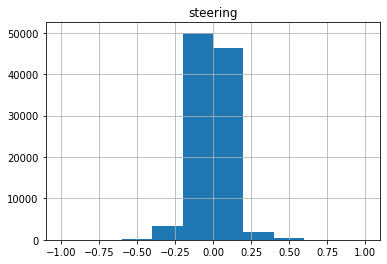

In [4]:
throttles, steerings = [], []
for st_path in veh_state_paths:
    array = np.load(st_path)
    throttles.append(array[-2])
    steerings.append(array[-1])
df = pd.DataFrame(
    data={"throttle":throttles, "steering":steerings}
)
df.hist("steering")

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
import os
import torch.utils.data as data
import matplotlib.pyplot as plt


In [11]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
#from torchnet.meter import AverageValueMeter
import torch.backends.cudnn as cudnn

In [3]:
data_dir = Path("/home/michael/Desktop/projects/ROAR/data/output")
center_depth_dir = data_dir / "front_depth"
veh_state_dir = data_dir / "vehicle_state"

center_depth_paths = [p for p in sorted(center_depth_dir.glob("*.npy", ), key=os.path.getmtime)]
veh_state_paths = [p for p in sorted(veh_state_dir.glob("*.npy", ), key=os.path.getmtime)]
print(f"Found { len(center_depth_paths)} data points")

Found 102172 data points


In [4]:
from utils import depth2colorjet, random_flip, crop_roi
import cv2
class CarDataset(data.Dataset):
    def __init__(self, X, y, img_width=64, img_height=64, should_take_roi=True, roi_min_height=30):
        self.X = X
        self.y = y
        self.img_width=img_width
        self.img_height=img_height
        self.should_take_roi = should_take_roi
        self.roi_min_height = roi_min_height
        
    def __getitem__(self, index):
        img_path = self.X[index]
        veh_state_path = self.y[index]
        steering_angle = np.load(veh_state_path)[-1]
        img = np.load(img_path)
        color_jet_rgb = depth2colorjet(img)
        color_jet_rgb = cv2.resize(color_jet_rgb, dsize=(self.img_width, self.img_height))
        if self.should_take_roi:
            color_jet_rgb = color_jet_rgb[30:self.img_width, :]
        
        # generate random noise to the image
        image, steering_angle = random_flip(color_jet_rgb, steering_angle)
        return image, steering_angle
    
    def __len__(self):
        return len(self.X)

    

In [5]:
car_dataset = CarDataset(X=center_depth_paths, y=veh_state_paths)


(<matplotlib.image.AxesImage at 0x7f9ac1f2c1c0>, -0.06670547276735306)

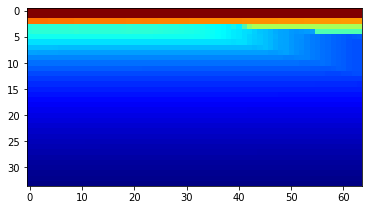

In [8]:
color_jet_depth, angle = car_dataset[100]
plt.imshow(color_jet_depth), angle

In [13]:
def toTensor(data, use_cuda):
    img, target = data
    img, target = x_np = torch.from_numpy(img), torch.from_numpy(np.array([target]))
    if use_cuda:
        img, target = img.cuda(), target.cuda()
    
    return img, target

In [28]:
class CarModel(nn.Module):
    def __init__(self):
        super(CarModel, self).__init__()
        self.conv_layers = nn.Sequential(
            # input is batch_size x 3 x 66 x 200
            nn.Conv2d(in_channels=3, 
                      out_channels=24, 
                      kernel_size=5, 
                      stride=2, 
                      bias=False),
            #nn.ELU(0.2, inplace=True),
            nn.ELU(),
            nn.Conv2d(24, 36, 5, stride=2, bias=False),
            nn.ELU(),
            nn.BatchNorm2d(36),
            
            nn.Conv2d(36, 48, 5, stride=2, bias=False),
            nn.ELU(),
            nn.BatchNorm2d(48),
            
            nn.Conv2d(48, 64, 3, stride=1, bias=False),
            nn.ELU(),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 64, 3, stride=1, bias=False),
            nn.ELU(),
            nn.Dropout(p=0.4)
        )
        self.linear_layers = nn.Sequential(
            #input from sequential conv layers
            nn.Linear(in_features=64*1*18, out_features=100, bias=False),
            nn.ELU(),
            nn.Linear(in_features=100, out_features=50, bias=False),
            nn.ELU(),
            nn.Linear(in_features=50, out_features=10, bias=False),
            nn.ELU(),
            nn.Linear(in_features=10, out_features=1, bias=False))
        self._initialize_weights()
        
    # custom weight initialization
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                init.normal(m.weight, mean=0, std=0.02)
            elif isinstance(m, nn.BatchNorm2d):
                init.normal(m.weight, mean=1, std=0.02)
                init.constant(m.bias, 0)

    def forward(self, input):
        print(input.shape)
        output = self.conv_layers(input)
        output = output.view(output.size(0), 64*1*18)
        output = self.linear_layers(output)
        return output   

In [29]:
model = CarModel()
img_tensor, target_tensor = toTensor((color_jet_depth, angle), use_cuda=False)
model(img_tensor)

torch.Size([34, 64, 3])


/tmp/ipykernel_25580/127118823.py:41: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight, mean=0, std=0.02)
/tmp/ipykernel_25580/127118823.py:43: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight, mean=1, std=0.02)
/tmp/ipykernel_25580/127118823.py:44: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [24, 3, 5, 5], but got 3-dimensional input of size [34, 64, 3] instead